<a href="https://www.kaggle.com/code/antongalysh/transfer-learning?scriptVersionId=228545026" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Імпорт бібліотек

In [1]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

## Створення ImageFolder

In [2]:
data_dir = '/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification'

# Створіть екземпляр ImageFolder
dataset = datasets.ImageFolder(root=data_dir)

**Пояснення:**

* Імпортуємо необхідні бібліотеки: `torch` для основних операцій PyTorch та `datasets` і `transforms` з `torchvision`.
* `datasets.ImageFolder` використовується для створення екземпляру, що представляє набір даних.
* Аргумент `root` вказує кореневий каталог, що містить теки ваших класів.

**Розуміння атрибутів об'єкта ImageFolder:**

* **`classes`:** Цей атрибут є списком, що містить назви класів в алфавітному порядку, які відповідають назвам папок у вашому наборі даних.
* **`class_to_idx`:** Цей словник зіставляє назви класів (ключі) з відповідними цілочисельними індексами (значеннями).
* **`imgs`:** Цей список містить кортежі, де кожен кортеж представляє зображення та відповідну мітку класу (індекс).

In [3]:
dataset.classes

['Avulsion fracture',
 'Comminuted fracture',
 'Fracture Dislocation',
 'Greenstick fracture',
 'Hairline Fracture',
 'Impacted fracture',
 'Longitudinal fracture',
 'Oblique fracture',
 'Pathological fracture',
 'Spiral Fracture']

**Розбиття набору даних для навчання та валідації:**

* Поділ вашого набору даних на навчальний та валідаційний набори має вирішальне значення для оцінювання моделі. 
* Функція `random_split` у PyTorch дозволяє випадковим чином розділити набір даних у потрібних пропорціях.

In [4]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

# Зміна transformer після поділу

In [5]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Зміна розміру зображення до 224x224 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # нормалізація для моделей
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Зміна розміру зображення до 224x224 пікселів
    transforms.ToTensor(), # Перетворити зображення у тензори PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) # нормалізація для моделей
])


class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
test_data = TransformDataset(test_data, transform = test_transform)

**Пояснення:**

* Визначаємо бажане співвідношення розбиття (`train_ratio`) для навчальних даних.
* Функція `random_split` отримує набір даних та список довжин як аргументи. Довжини визначають кількість вибірок для кожного розбиття.
* Створює два нових набори даних (`train_data` та `val_data`), що представляють навчальну та валідаційну вибірки відповідно.

**5. Створення завантажувачів даних:**

* PyTorch's `DataLoader` допомагає керувати ефективним завантаженням даних під час навчання. Він дозволяє пакетно завантажувати дані, перемішувати зразки (необов'язково) і обробляти багатопроцесорні дані (необов'язково) для пришвидшення навчання.

Обчислити параметри для зображень можна і вручну, якщо у вас специфічні зображення

In [6]:
means = []
stds = []

for X, y in train_data:
    mean = torch.mean(X, dim=(1, 2))
    std = torch.std(X, dim=(1, 2))
    
    means.append(list(mean))
    stds.append(list(std))

means = torch.tensor(means)
stds = torch.tensor(stds)
    
mean = torch.mean(means, dim=(0))
std = torch.mean(stds, dim=(0))

# (3, 224, 224) -> (3)
# (904, 3) -> (3)
mean, std

(tensor([-0.5718, -0.4383, -0.2084]), tensor([1.0198, 1.0514, 1.0488]))

# Мій випадок

In [59]:
# train_data = datasets.ImageFolder(root=data_dir, transform=train_transform,
#                                   is_valid_file=lambda path: 'Train' in path)

# test_data = datasets.ImageFolder(root=data_dir, transform=test_transform,
#                                  is_valid_file=lambda path: 'Test' in path)

In [7]:
batch_size = 256

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

# Трансферне навчання

Трансферне навчання - це потужний метод глибокого навчання, який дозволяє використовувати знання, отримані від попередньо навченої моделі на великому наборі даних, для вирішення нової, пов'язаної з нею задачі. Уявіть, що ви навчили величезну модель ідентифікувати тисячі об'єктів. Навчання з перенесенням дозволяє використовувати цю попередньо навчену модель як відправну точку для нового завдання, наприклад, класифікації різних типів квітів. Повторно використовуючи вивчені ознаки з попередньо навченої моделі, ви можете досягти хороших результатів у новому завданні з меншою кількістю даних і меншим часом навчання порівняно з навчанням моделі з нуля.

**Переваги навчання з перенесенням:**

* **Скорочення часу навчання:** Попередньо навчені моделі вже вивчили потужні представлення ознак з великих наборів даних. Це економить час і обчислювальні ресурси при застосуванні до нових завдань.
* **Покращена продуктивність:** Трансферне навчання часто дозволяє досягти кращої точності на нових завданнях, особливо з обмеженими даними, порівняно з навчанням моделі з нуля.
* **Ефективна розробка моделей:** Трансферне навчання дозволяє будувати складні моделі навіть з меншими наборами даних, прискорюючи процес розробки.

![](https://www.researchgate.net/publication/342400905/figure/fig4/AS:905786289057792@1592967688003/The-architecture-of-our-transfer-learning-model.jpg)

# **Популярні попередньо навчені моделі для комп'ютерного зору:**

* **ImageNet:** Великий набір даних з мільйонами мічених зображень у тисячах категорій об'єктів. Популярні моделі, навчені на ImageNet, включають:
* **VGG (Very Deep Convolutional Neural Network):** Класична архітектура з глибокими згортковими шарами для вилучення ознак.
* **ResNet (залишкова мережа):** Вирішує проблему зникаючого градієнта в глибоких мережах, що призводить до кращої продуктивності.
* **DenseNet (щільно зв'язана згорткова мережа):** Покращує розповсюдження ознак для складних задач з меншою кількістю параметрів.

![](https://glassboxmedicine.com/wp-content/uploads/2020/12/vgg-resnet-googlenet-1.png?w=1024)

# [Моделі для різних задач](https://pytorch.org/vision/0.9/models.html#torchvision-models)

# **Заморожування проти тонкого налаштування параметрів:**

* **Заморожування параметрів:** Передбачає, що ваги (параметри) попередньо навченої моделі не підлягають навчанню під час процесу перенесення. Це гарантує, що основні шари виділення ознак залишаються незмінними і фокусує навчання на кінцевих шарах, адаптованих до нового завдання.
* **Точне налаштування:** Передбачає, що деякі або всі параметри попередньо навченої моделі можуть бути навчені під час навчання з перенесенням. Це дозволяє моделі адаптувати вивчені функції до нової задачі, використовуючи при цьому попередньо набуті знання. Точне налаштування зазвичай застосовується до останніх шарів попередньо навченої моделі, ближче до виходу.

# [Посилання на документацію по моделях](https://pytorch.org/vision/stable/models.html#classification)

In [9]:
for X_batch, y_batch in train_loader:
    break

In [12]:
X_batch.requires_grad

False

In [14]:
len(dataset.classes)

10

In [8]:
from torchvision import models

models.vgg19(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 174MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [51]:
models.resnet34(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 166MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
from torch import nn
import torch.nn.functional as F
import numpy as np


class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        vgg = models.vgg19(pretrained=True)
        
        # від'єднання градієнтів
        for param in vgg.parameters():
            param.requires_grad = False
        
        # деактивація останнього шару
        vgg.classifier = nn.Identity()  # шар який нічого не робить 
        self.vgg = vgg
        
        # створення потрібних шарів
        self.linear1 = nn.Linear(25088, 10)
        #self.linear2 = nn.Linear(1000, 10)

        self.drop = nn.Dropout(p=0.2)
        

    def forward(self, x):
        out = self.vgg(x)
        out = out['output']

        out = self.drop(out)

        out = self.linear1(out)
        # F.relu(out)
        # out = self.linear2(out)

        return out


model = TransferLearningClassifier().to(device)
model

TransferLearningClassifier(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=T

In [17]:
!pip install -q torchsummary

In [22]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [23]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [24]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (Adam) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [25]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=10,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TransferLearningClassifier, opt=Adam(lr=0.001000), epochs=10, device=cuda

Epoch    1   17sec	loss:       2.76	val_loss:       2.99	accuracy_score:      0.146	val_accuracy_score:      0.213	
Epoch    2   13sec	loss:       1.89	val_loss:       2.23	accuracy_score:      0.429	val_accuracy_score:      0.316	
Epoch    3   12sec	loss:       1.33	val_loss:          2	accuracy_score:      0.592	val_accuracy_score:      0.404	
Epoch    4   13sec	loss:      0.951	val_loss:       2.04	accuracy_score:      0.688	val_accuracy_score:      0.404	
Epoch    5   13sec	loss:      0.655	val_loss:       1.95	accuracy_score:      0.822	val_accuracy_score:      0.436	
Epoch    6   13sec	loss:      0.497	val_loss:       1.88	accuracy_score:      0.866	val_accuracy_score:       0.44	
Epoch    7   13sec	loss:      0.371	val_loss:       1.92	accuracy_score:      0.921	val_accuracy_score:      0.449	
Epoch    8   13sec	loss:      0.272	val_loss:       1.94	accuracy_score:      0.957	val_acc

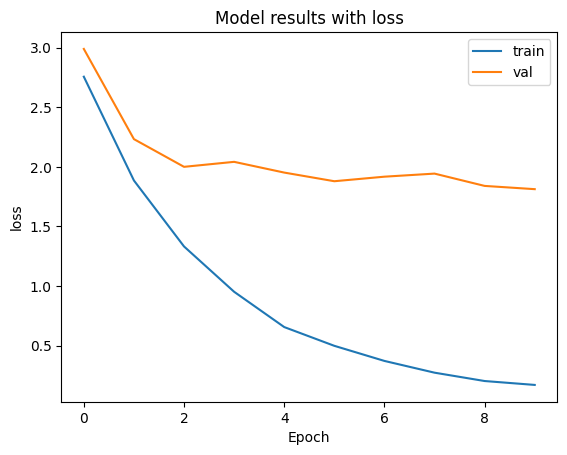

In [26]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

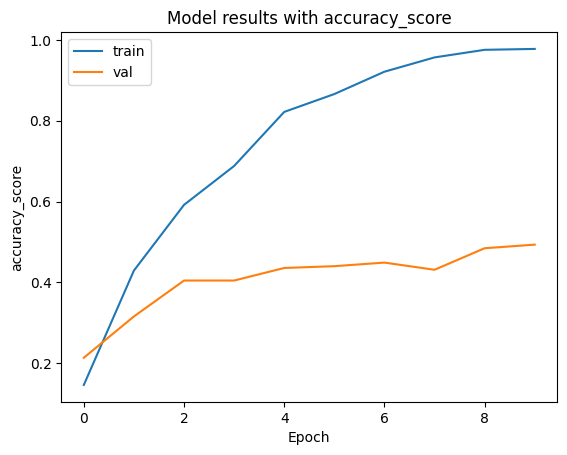

In [27]:
plot_metric(history, 'accuracy_score')

[]

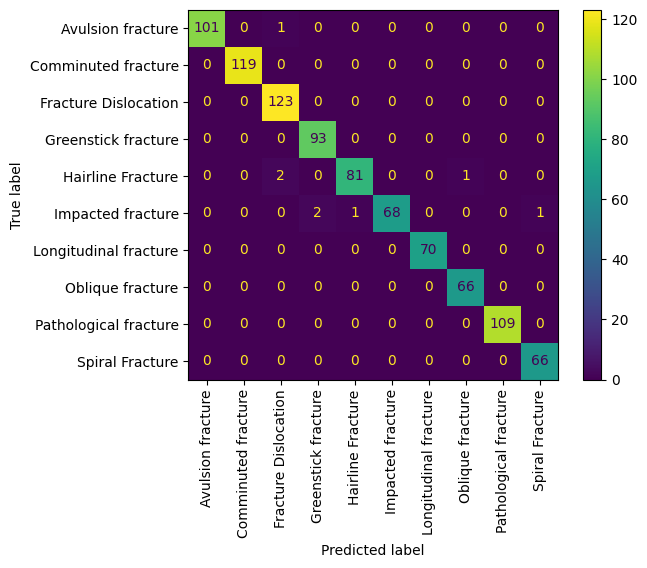

In [29]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to(device)
model.eval()

y_pred = []
y_test = []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        y_pred_ = model(X)
        y_pred_ = y_pred_.argmax(-1).cpu()
        
        y_pred.extend(y_pred_)
        y_test.extend(y)


ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=dataset.classes)
plt.xticks(rotation=90)
plt.plot()

In [73]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=dataset.classes))

                       precision    recall  f1-score   support

    Avulsion fracture       0.33      0.30      0.32        20
  Comminuted fracture       0.44      0.41      0.43        29
 Fracture Dislocation       0.33      0.35      0.34        37
  Greenstick fracture       0.49      0.59      0.54        32
    Hairline Fracture       0.22      0.26      0.24        19
    Impacted fracture       0.00      0.00      0.00        12
Longitudinal fracture       0.00      0.00      0.00        14
     Oblique fracture       0.00      0.00      0.00        22
Pathological fracture       0.38      0.81      0.52        27
      Spiral Fracture       0.42      0.38      0.40        13

             accuracy                           0.36       225
            macro avg       0.26      0.31      0.28       225
         weighted avg       0.30      0.36      0.32       225



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


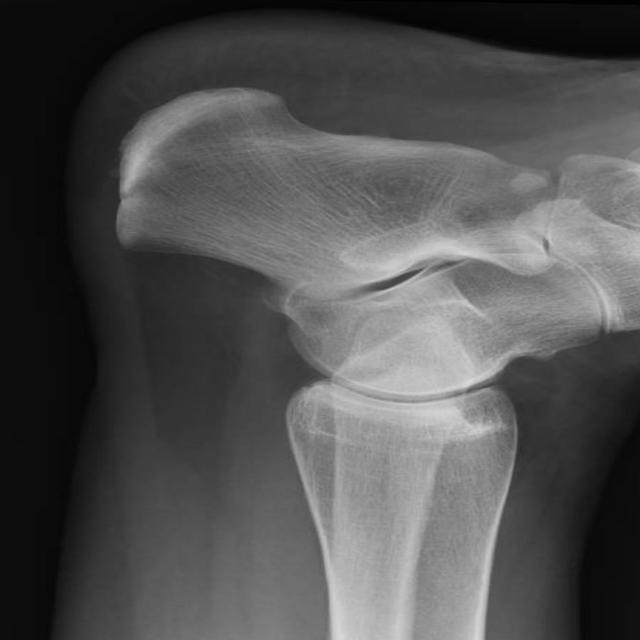

In [30]:
import PIL.Image

img = PIL.Image.open('/kaggle/input/bone-break-classification-image-dataset/Bone Break Classification/Bone Break Classification/Hairline Fracture/Test/0-_jumbo_jpeg.rf.d39588df830d194c0cda3b800664160b.jpg')
img

In [32]:
img_tensor = test_transform(img)
img_tensor

tensor([[[-1.8953, -1.8953, -1.8953,  ..., -2.1008, -2.1008, -2.1008],
         [-1.9124, -1.9124, -1.9124,  ..., -2.0152, -2.0494, -2.0665],
         [-1.9295, -1.9295, -1.9295,  ..., -1.8953, -1.9124, -1.9638],
         ...,
         [-1.8953, -1.8953, -1.8953,  ..., -1.8439, -1.8439, -1.8439],
         [-1.8953, -1.8953, -1.8953,  ..., -1.8439, -1.8439, -1.8439],
         [-1.8953, -1.8953, -1.8953,  ..., -1.8439, -1.8439, -1.8439]],

        [[-1.8081, -1.8081, -1.8081,  ..., -2.0182, -2.0182, -2.0182],
         [-1.8256, -1.8256, -1.8256,  ..., -1.9307, -1.9657, -1.9832],
         [-1.8431, -1.8431, -1.8431,  ..., -1.8081, -1.8256, -1.8782],
         ...,
         [-1.8081, -1.8081, -1.8081,  ..., -1.7556, -1.7556, -1.7556],
         [-1.8081, -1.8081, -1.8081,  ..., -1.7556, -1.7556, -1.7556],
         [-1.8081, -1.8081, -1.8081,  ..., -1.7556, -1.7556, -1.7556]],

        [[-1.5779, -1.5779, -1.5779,  ..., -1.7870, -1.7870, -1.7870],
         [-1.5953, -1.5953, -1.5953,  ..., -1

In [36]:
img_tensor = img_tensor.unsqueeze(0)

In [37]:
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [40]:
with torch.no_grad():
    model = model.to('cpu')
    logits = model(img_tensor)

logits

tensor([[-0.8209, -1.1902, -0.1327, -4.1877,  2.8816, -1.7112, -0.8069, -1.6452,
          0.8454, -0.4988]])

In [41]:
proba = F.softmax(logits)

/tmp/ipykernel_34/1132574506.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  proba = F.softmax(logits)


In [42]:
proba

tensor([[1.8939e-02, 1.3091e-02, 3.7694e-02, 6.5340e-04, 7.6796e-01, 7.7753e-03,
         1.9208e-02, 8.3057e-03, 1.0024e-01, 2.6138e-02]])

In [43]:
idx = proba.argmax()
idx

tensor(4)

In [46]:
dataset.classes[idx]

'Hairline Fracture'

In [48]:
proba[0, idx]

tensor(0.7680)